In [10]:
import pandas as pd

import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# modeling
from keras.utils import pad_sequences
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
import keras

sns.set()

In [3]:
# Expects: run the code on lstm_traffic_only_1 to generate the csv info

traffic_df = pd.read_csv("../data/traffic_pre_lstm.csv")
traffic_df['timestamp'] = pd.to_datetime(traffic_df['timestamp'])
traffic_df.set_index('timestamp', inplace=True)
traffic_df.head()

,610,611,612,613,614,615,616,617,618,619,...,1049,1050,1051,1052,1053,1054,1055,1056,1057,1058
timestamp,,,,,,,,,,,,,,,,,,,,,
2014-08-01 08:10:00,41.0,0.0,52.0,38.0,40.0,86.0,62.0,44.0,40.0,23.0,...,16.0,20.0,21.0,50.0,19.0,48.0,34.0,0.0,65.0,32.000000
2014-08-01 08:15:00,41.0,0.0,52.0,40.0,40.0,86.0,62.0,45.0,40.0,23.0,...,16.0,35.0,21.0,50.0,21.0,69.0,34.0,0.0,69.0,32.000000
2014-08-01 08:20:00,41.0,0.0,61.0,44.0,40.0,33.0,75.0,49.0,40.0,23.0,...,16.0,35.0,21.0,50.0,21.0,70.0,36.0,0.0,67.0,28.000000
2014-08-01 08:25:00,41.0,0.0,61.0,45.0,40.0,33.0,59.0,53.0,44.0,23.0,...,22.0,37.0,21.0,57.0,22.0,56.0,46.0,0.0,58.0,28.000000
2014-08-01 08:30:00,41.0,0.0,38.0,43.0,40.0,77.0,59.0,47.0,36.0,23.0,...,22.0,23.0,14.0,57.0,22.0,51.0,46.0,0.0,60.0,27.666667


In [5]:
traffic_df.shape

(29984, 449)

In [8]:
training_sample = traffic_df[100:20000]
validation_sample = traffic_df[20001:]

In [9]:

# set predictive horizon and sequence length
ph = 5
seq_length = 12

# features to randomly sample without replacement
# must be a value between 1 to 449, inclusive 
features = 449 

sensor = pd.Series(training_sample.columns).sample(
    features, replace=False).sort_values().to_list()

print(sensor)

seq_arrays = []
seq_labs = []

training_features = training_sample[sensor]

for i in range(training_features.shape[0]-seq_length-ph):
    seq_arrays.append(training_features.iloc[i:seq_length+i].to_numpy())
    seq_labs.append(training_features.iloc[seq_length+ph+i])

seq_arrays = np.array(seq_arrays, dtype=object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype=object).astype(np.float32)

['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020', '1021', '1022', '1023', '1024', '1025', '1026', '1027', '1028', '1029', '1030', '1031', '1032', '1033', '1034', '1035', '1036', '1037', '1038', '1039', '1040', '1041', '1042', '1043', '1044', '1045', '1046', '1047', '1048', '1049', '1050', '1051', '1052', '1053', '1054', '1055', '1056', '1057', '1058', '610', '611', '612', '613', '614', '615', '616', '617', '618', '619', '620', '621', '622', '623', '624', '625', '626', '627', '628', '629', '630', '631', '632', '633', '634', '635', '636', '637', '638', '639', '640', '641', '642', '643', '644', '645', '646', '647', '648', '649', '650', '651', '652', '653', '654', '655', '656', '657', '658', '659', '660', '661', '662', '663', '664', '665', '666', '667', '668', '669', '670', '671', '672', '673', '674', '675', '676', '677', '678', '679', '680', '681', '682', '683', '684', '6

In [11]:
# create validation dataset
val_arrays = []
val_labs = []

validation_features = validation_sample[sensor]

for i in range(validation_features.shape[0]-seq_length-ph):
    if i < 12:
        val_arrays.append(validation_features.iloc[:(i+1)].to_numpy())
        val_labs.append(validation_features.iloc[:(i+ph+1)].to_numpy()[-1])
    else:
        val_arrays.append(validation_features.iloc[i:seq_length+i].to_numpy())
        val_labs.append(validation_features.iloc[seq_length+i+ph])

val_arrays = pad_sequences(val_arrays, padding='pre',
                           dtype=object).astype(np.float32)

val_labs = np.array(val_labs, dtype=object).astype(np.float32)

In [12]:
# define path to save model
model_path = 'lstm_traffic_alternative.keras'

# build the network
features = len(sensor)
output_size = features

model = Sequential()

model.add(LSTM(
    input_shape=(seq_length, features),
    units=100,
    activation="relu",
    return_sequences=True))
model.add(Dropout(0.025))

model.add(LSTM(
    units=32,
    activation="relu",
    return_sequences=True))

model.add(LSTM(
          units=16,
          activation="relu",
          return_sequences=False))

model.add(Dense(units=output_size, activation="linear"))

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

print(model.summary())

# fit the network
history = model.fit(seq_arrays,
                    seq_labs,
                    epochs=1000,
                    batch_size=80,
                    validation_split=0.05,
                    verbose=2,
                    callbacks=[
                        keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            min_delta=0.1,
                            patience=5,
                            verbose=0,
                            mode='min'),
                        keras.callbacks.ModelCheckpoint(
                            model_path,
                            monitor='val_loss',
                            save_best_only=True,
                            mode='min',
                            verbose=0)
                    ])

# list all data in history
print(history.history.keys())

/opt/homebrew/anaconda3/envs/masters/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 100)        │       220,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 12, 32)         │        17,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 449)            │         7,633 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 247,793 (967.94 KB)

 Trainable params: 247,793 (967.94 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/1000
237/237 - 6s - 26ms/step - loss: 729.6939 - mse: 729.6939 - val_loss: 240.2538 - val_mse: 240.2538
Epoch 2/1000
237/237 - 5s - 21ms/step - loss: 189.9188 - mse: 189.9188 - val_loss: 236.4689 - val_mse: 236.4689
Epoch 3/1000
237/237 - 5s - 22ms/step - loss: 182.3105 - mse: 182.3105 - val_loss: 249.8849 - val_mse: 249.8849
Epoch 4/1000
237/237 - 5s - 22ms/step - loss: 172.9351 - mse: 172.9351 - val_loss: 196.9854 - val_mse: 196.9854
Epoch 5/1000
237/237 - 5s - 21ms/step - loss: 161.1447 - mse: 161.1447 - val_loss: 187.5323 - val_mse: 187.5323
Epoch 6/1000
237/237 - 5s - 23ms/step - loss: 156.7153 - mse: 156.7153 - val_loss: 174.7906 - val_mse: 174.7906
Epoch 7/1000
237/237 - 6s - 24ms/step - loss: 152.3194 - mse: 152.3194 - val_loss: 171.8913 - val_mse: 171.8913
Epoch 8/1000
237/237 - 6s - 23ms/step - loss: 149.3521 - mse: 149.3521 - val_loss: 166.4472 - val_mse: 166.4472
Epoch 9/1000
237/237 - 6s - 24ms/step - loss: 147.4585 - mse: 147.4585 - val_loss: 163.2238 - val_m

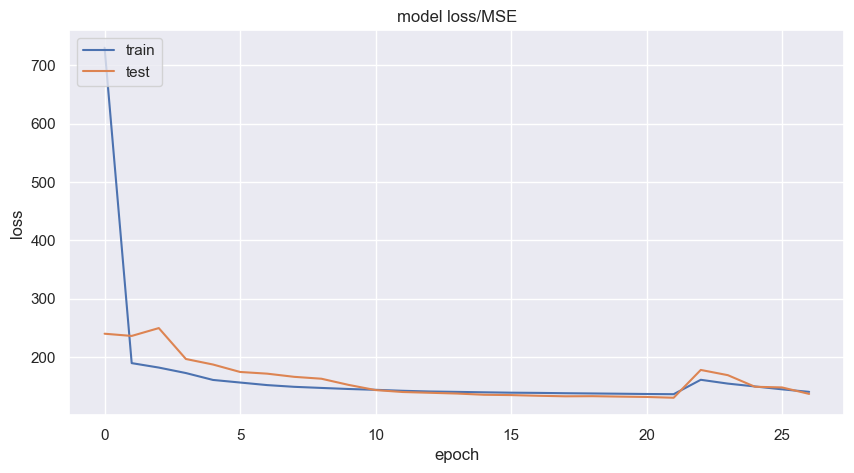

In [14]:
# summarize history for Loss/MSE
fig_acc = plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss/MSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

312/312 - 2s - 5ms/step - loss: 174.2645 - mse: 174.2645

MSE: 174.2645263671875


312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


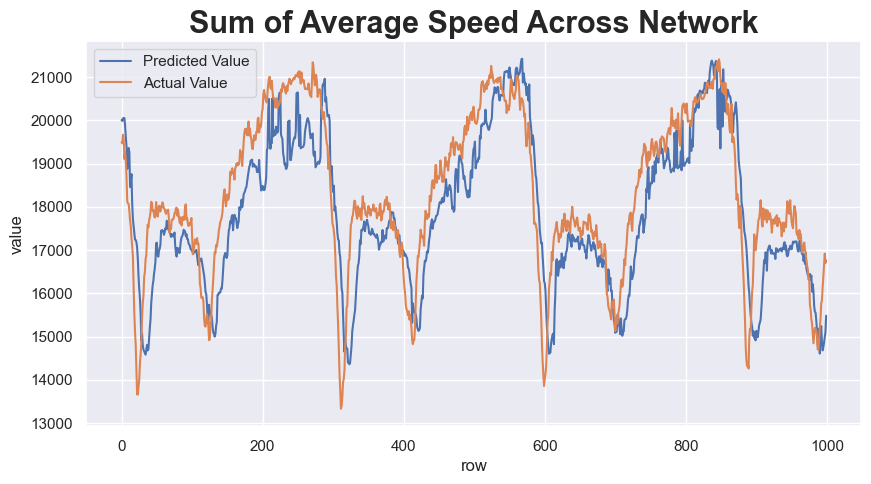

In [16]:
y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

# aggregating for easier visualization
y_pred_dv = [row.sum() for row in y_pred_test]
y_true_dv = [row.sum() for row in y_true_test]

start = 5000
ts = 1000

fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_dv[start:start+ts], label='Predicted Value')
plt.plot(y_true_dv[start:start+ts], label='Actual Value')
plt.title('Sum of Average Speed Across Network',
          fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()